# Градиентное обучение на примере линейной регрессии

## Исходные данные

Для этого занятия нам понадобится файл `non_linear.csv` который хранится в [директории курса на Google Drive](https://drive.google.com/file/d/1prHJVpHn0N5y1BqLQQ2Hpx5OP8uKIXjT/view?usp=sharing)

Скопируйте файл к себе в родительскую директорию **hse_nlp_2021**

In [ ]:
import logging
import os
import shutil 

import numpy as np
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

2022-01-24 16:11:29,034 : INFO : Инициализировали логгер
2022-01-24 16:12:00,388 : INFO : Подключили диск


Mounted at /content/drive


2022-01-24 16:12:00,651 : INFO : Содержимое директории /content/drive/MyDrive/hse_nlp_2021: ['events.csv', 'corpora', 'nltk_data_old', 'nltk_data', '1000k_memes_ocr.tar.gz', 'logs', 'sklearn_data', 'nyt-ingredients-snapshot-2015.csv', 'insurance.csv', 'non_linear.csv', 'my_little_recsys', 'optimal_push_time']


Прочитаем `non_linear.csv`

In [ ]:
import os

import numpy as np
import pandas as pd

raw_data_file = os.path.join(root_data_dir, 'client_segmentation.csv')
data = pd.read_csv(raw_data_file, sep=',')

data = data[
            (data.x_train > 1) & (data.x_train < 5)
].copy()
data.head()

2022-01-24 16:13:32,725 : INFO : NumExpr defaulting to 2 threads.


,x_train,y_train
5,1.182421,1.860341
6,1.251605,1.878928
7,1.270474,2.430015
8,1.402553,2.327856
9,1.427711,2.203649


Визуализируем данные

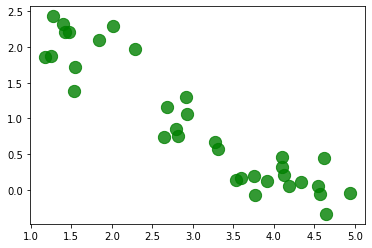

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(
    data.x_train, data.y_train,
    s=40, c='g', marker='o', alpha=0.8
)
plt.show()

Создадим две отдельные переменные

* $y$ для целевой переменной из столбца `y_train`. Удалим из исходного датафрейма с помощью `.drop()`
* Все оставшиеся после удаления столбцы - это матрица объекты-признаки $X$

Для матрицы объекты-признаки добавляем "дефолтный" признак из единиц.

In [ ]:
num_examlpes = data.shape[0]
num_features = data.shape[0] - 1  # вычитаем единичку т.к. убрали столбец y
X = np.zeros((num_examlpes, num_features + 1))  # размерность увеличилась на дефолтный столбец


#-------- ВАШ КОД ТУТ -------------------



#-----------------------------------------

Создаём отложенную выборку для валидации - см. предыдущий семинар

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Аналитическое решение

Для начала напишем код для аналитического вычисления коэффициентов линейной регрессии по формуле $\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}$


In [ ]:
from numpy.linalg import inv
import numpy as np

# вычисляем к-ты линейной регрессии
w_analytic = np.zeros(num_features)
#-------- ВАШ КОД ТУТ -------------------



#-----------------------------------------

print(f'Аналитически определённые коэффициенты {w_analytic}')

NameError: ignored

$$
y = x_0*2.98 + x*(-0.67)
$$

Плучите коэффициенты из класса `LinearRegression` - мы уже делали так на прошлом семинаре

In [ ]:
from sklearn.linear_model import LinearRegression
#-------- ВАШ КОД ТУТ -------------------



#----------------------------------------

LinearRegression()

Сравните по евклидовому расстоянию коэффициенты из класса `LinearRegression` и полученные аналитическим способом

In [ ]:
from numpy.linalg import inv, norm

#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

Проверка на правильность - пишем юнит-тест!

In [ ]:
import unittest


class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(linalg_norm, 0.000000, places=6)

unittest.main(argv=[''], verbosity=2, exit=False)

## Градиентный спуск из sklearn

Используем готовую реализацию и функцию [.fit_partial()](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning)

Для градиентного спуска мы используем готовый класс [sklearn.linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html). Класс принимает следующие параметры

* `learning_rate='constant'` используем самую простую модификацию спуска из нескольких возможных (см. доументацию)
* `eta0=0.009` - шаг градиентного спуска, в формуле мы его обозначали буквой $\eta$
* `fit_intercept=True` - чтобы обучить коэффициент при "свободном члене" $w_0$ линейной регрессии (см. лекцию)
* `random_state=RANDOM_SEED` - этот параметр встречали ранее в этом модуле, он нужен для воспроизводимости вычислений.

Псевдокод решения (нужно закодить самостоятельно, если возникнут сложности - подсмотреть в лекции):

* инициализируем `w_current` рандомом, `weight_evolution` и `rmse_evolution` пустыми списками, и критерий остановки $\varepsilon=0.0001$
* задаём максимальное число шагов `800` и далее на каждом шаге
  * вызываем `.partial_fit`
  * `.coef_` содержит текущие веса - применяем [from scipy.spatial.distance.euclidean](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean) и сверяем с критерием остановки. Если критерий не выполняется - обновляем rmse с помощью [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) на `y_valid` и предикт на `X_valid` и переназначаем `w_current` на атрибут `.coef_.copy()`

Когда критерий остановки выполнился - визуализируем `rmse_evolution`, мы должны увидеть т.н. кривую обучения с помощью `.plot(range(step), rmse_evolution)`

Новая библиотека в нашем арсенале  - scipy, изучите её документацию

In [ ]:
y = data.y_train  # таргет
X = data.drop('y_train', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

2022-01-24 17:55:49,213 : INFO : Обучение закончилось
2022-01-24 17:55:49,216 : INFO : Количество пройденных итераций 160


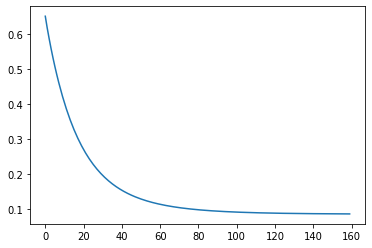

In [ ]:
from sklearn.linear_model import SGDRegressor
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_squared_error

#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

Визуализируем решение на графике

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  "X does not have valid feature names, but"


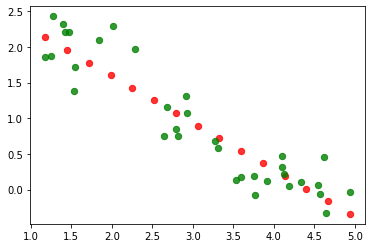

Готово! Мы получили решение задачи линейной регрессии, обучив параметры линейной регресии небольшими "шажками". Мы не использовали сложных матричных вычислений - тем не менее получили линию регрессии, которая лежит в середине облака точек. Когда стоит использовать градиентный спуск в реальных задачах?

* когда данных очень много - в этом случае компьютер может не справится с перемножением матриц
* когда нужно контролировать точность обучения - остановить итерации можно в любой момент (не дожидаясь, пока дойдем до "идеальных" значений.

Когда не стоит применять градиентный спуск? Когда данных мало - в этом случае лучше воспользоваться точным решением

**Практическое задание** очевидно, что чем больше шаг градиентного спуска (параметр *eta0* класса *SGDRegressor*), тем быстрее мы придём к оптимальным значениям. Используя под выше, поиграйтесь с параметром *eta0* и добейтесь , чтобы градиентный спуск закончился быстрее, чем за 200 шагов.

Сколько шагов у вас получилось? Какое качество *RMSE* у Вашего решения на валидационной выборке

In [ ]:
#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

## Реализация GD на python

Формулы см. в лекции

In [ ]:
import numpy as np

def gradient(X, y, w, alpha=0) -> np.array:
    """Вычисляем градиент в точке"""
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = X.dot(w.T)
    # вычисляем ошибку прогноза
    error = y - y_hat
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    pointwise_errors = np.multiply(X, error) + X
    # вычисляем градиент и ошибку
    grad = pointwise_errors.sum(axis=0)*(-1.0)*2.0 / n
    return grad, error

Делаем шаг градиентного спуска

In [ ]:
from scipy.spatial import distance

def eval_w_next(X, y, eta, w_current):
    """Делаем шаг градиентного спуска"""
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current, w_next)
    return (w_next, weight_evolution, grad)

Повторяем шаги (1,2) до сходимости

In [ ]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 ==0:
            logger.info("step %s |w-w_next|=%.5f, grad=%s", step, weight_evolution, grad)
    return w

Запускаем обучение

In [ ]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(
    X,
    data['y_train'].values.reshape(-1, 1),
    eta=0.008
)

У нас произошло несколько сотен итераций, на каждой итерации мы:
* вычисляем вектор весов
* смотрим расстояние между новым вектором весов и векторов весов с предыдущего шага
* если изменения в векторе весов небольшие (скажем, четвёртый знак поcле запятой) - останавливаем итерации

Когда вектор перестаёт меняться - говорят, что алгоритм "сошёлся" (имеется в виду сходимость к оптимальной точке) - это значит, что итерации можно останавливать.

In [ ]:
support = np.linspace(X.min(), X.max(), num=100)
# делаем предикт - считаем предсказания модели в каждой точке обучающей выборке в виде y=X*w
y_hat = np.hstack([
    np.ones(support.size).reshape(-1, 1),
    support.reshape(-1, 1)
]).dot(w.T)

визуализируем результаты

In [ ]:
# строим график
plt.plot(support, y_hat, 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()